<a href="https://colab.research.google.com/github/kkrphm/project-Models/blob/main/Proposed_Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Connect to Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Libraries**

In [ ]:
# For Data Processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.utils  import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score,roc_auc_score, classification_report,roc_curve,auc
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array,ImageDataGenerator, load_img
from keras.utils import np_utils
from tensorflow.keras.utils  import to_categorical
from numpy import expand_dims
from sklearn.preprocessing import LabelBinarizer

# For DL Models
import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D,BatchNormalization,LayerNormalization, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model,load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import *
from keras.applications import *

# For Data Visualization
import seaborn as sns
import cv2
import plotly.graph_objs as go
from plotly import tools
%matplotlib inline
import matplotlib.pyplot as plt #used for plotting and analyzing data
import matplotlib
andy_theme = {'axes.grid': True,
              'grid.linestyle': '--',
              'legend.framealpha': 1,
              'legend.facecolor': 'white',
              'legend.shadow': True,
              'legend.fontsize': 14,
              'legend.title_fontsize': 16,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14,
              'axes.labelsize': 16,
              'axes.titlesize': 20,
              'axes.linewidth':'1',
              'axes.edgecolor':'0',
              'figure.dpi': 600
               }

# Miscellaneous       
import random
import warnings
warnings.filterwarnings("ignore")
import os #file I/O



## **Training & Validation Datasets**

In [ ]:
train_data_dir = '/content/drive/MyDrive/Project (1)/Brain_Tumor/Training' #data is already in colab file
validation_data_dir = '/content/drive/MyDrive/Project (1)/Brain_Tumor/Testing'
test_data_dir='/content/drive/MyDrive/Project (1)/Brain_Tumor/Testing'
Model_File_path='/content/drive/MyDrive/6-model/'
nb_train_samples =5722
nb_validation_samples =1311
nb_test_samples =153
epochs = 15
batch_size = 32
num_classes=4
seed=123
# input image dimensions
img_rows, img_cols = 512,512
input_shape = (img_rows, img_cols, 3)
IMG_HEIGHT = 512
IMG_WIDTH = 512

# **Data Augmentation**

In [ ]:

# using the ImageDataGenerator to prepare the images (Resize, nomalize, etc)

train_generator = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0.2,
                                    shear_range=0.2,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest") 
 

  
val_generator = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0.2,
                                    shear_range=0.2,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest")

test_generator = ImageDataGenerator(rescale=1. / 255)


In [ ]:
# Creating the train and test data.

train = train_generator.flow_from_directory(train_data_dir, target_size=(64,64),
                                              batch_size=64, class_mode= "categorical", color_mode='grayscale')

valadition = val_generator.flow_from_directory(validation_data_dir, target_size=(64,64),
                                              batch_size=64, class_mode= "categorical", color_mode='grayscale')

test = test_generator.flow_from_directory(test_data_dir, target_size=(64,64),
                                              shuffle=False,batch_size=64, class_mode= "categorical", color_mode='grayscale')


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# **Let's visualize the data.**

In [ ]:
index = ['glioma','meningioma','notumor','pituitary']
trained_classes=[]
for i in train.classes:
  trained_classes.append(index[i])
print(trained_classes[:5])
test_classes=[]
for i in test.classes:
  test_classes.append(index[i])
print(test_classes[:5])

['glioma', 'glioma', 'glioma', 'glioma', 'glioma']
['glioma', 'glioma', 'glioma', 'glioma', 'glioma']


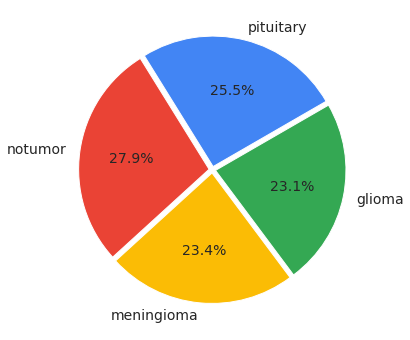

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in trained_classes if x=='pituitary']),
         len([x for x in trained_classes if x=='notumor']),
         len([x for x in trained_classes if x=='meningioma']),
         len([x for x in trained_classes if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);

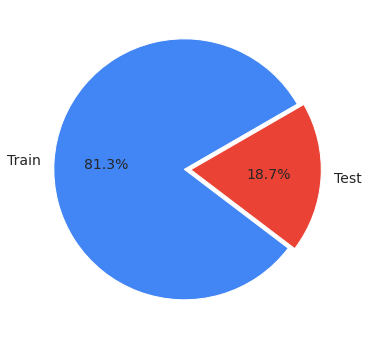

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(trained_classes), len(test_classes)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

#### **Ploting a image of each brain tumor type**

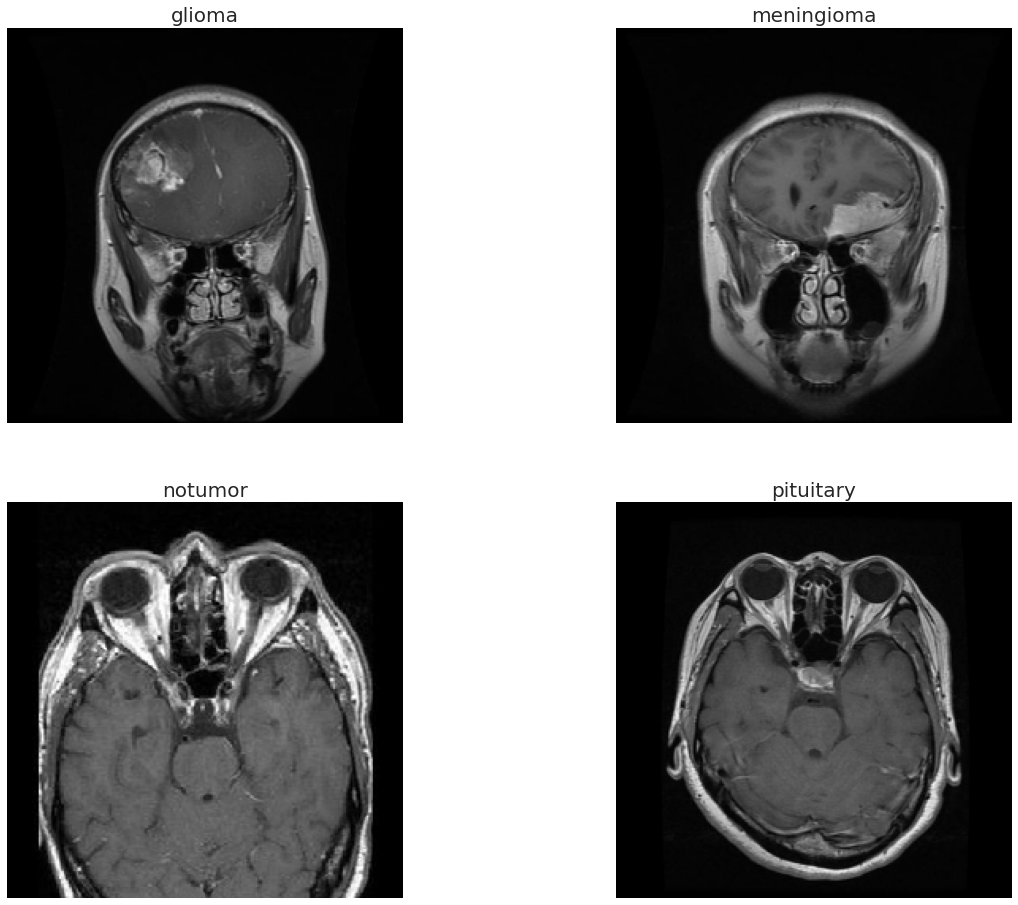

In [ ]:
plt.figure(figsize=(20, 16))

images_path = ['/glioma/Tr-glTr_0000.jpg', '/meningioma/Tr-meTr_0000.jpg', '/notumor/Tr-noTr_0000.jpg', '/pituitary/Tr-piTr_0000.jpg']

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    # plt.grid()
    img = cv2.imread(train_data_dir + images_path[i])
    img = cv2.resize(img, (250, 250))
    plt.imshow(img)
    plt.axis('off')
    plt.title(list(train.class_indices.keys())[i])

# **Modelling**


# **CNN - Model 1**

In [ ]:
# 96.95%

model1 = Sequential()

# Convolutional layer 1
model1.add(Conv2D(32,(3,3), input_shape=(64, 64, 1), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional layer 2
model1.add(Conv2D(32,(3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())

# Neural network

model1.add(Dense(units= 252, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=252, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=4, activation='softmax'))

model1.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0001, clipvalue=0.5)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy',
                   metrics= ['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 32)       128       
 hNormalization)                                                 
                                                        

#**Trainig model 1**

In [ ]:
# Creating callbacks for the model.
# If the model dosen't continue to improve (loss), the trainning will stop.

# Stop training if loss doesn't keep decreasing.
model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)

# Automatically saves the best weights of the model, based on best val_accuracy
model1_mcp = ModelCheckpoint(filepath = Model_File_path+'model1_weights.h5', monitor = 'val_accuracy', 
                      save_best_only = True, verbose = 1)
batch_size=64
# Fiting the model.
history1 = model1.fit(train, steps_per_epoch=nb_train_samples//batch_size, epochs=100, validation_data=valadition, validation_steps= nb_validation_samples//batch_size,
                     callbacks=[model1_es, model1_rlr, model1_mcp])

Epoch 1/100
89/89 [==============================] - ETA: 0s - loss: 1.1112 - accuracy: 0.6087 
Epoch 1: val_accuracy improved from -inf to 0.30781, saving model to /content/drive/MyDrive/6-model(1-3)/model1_weights.h5
89/89 [==============================] - 2806s 31s/step - loss: 1.1112 - accuracy: 0.6087 - val_loss: 2.8127 - val_accuracy: 0.3078 - lr: 0.0010
Epoch 2/100
89/89 [==============================] - ETA: 0s - loss: 0.7604 - accuracy: 0.7043
Epoch 2: val_accuracy did not improve from 0.30781
89/89 [==============================] - 27s 302ms/step - loss: 0.7604 - accuracy: 0.7043 - val_loss: 3.8479 - val_accuracy: 0.2320 - lr: 0.0010
Epoch 3/100
89/89 [==============================] - ETA: 0s - loss: 0.6643 - accuracy: 0.7450
Epoch 3: val_accuracy did not improve from 0.30781
89/89 [==============================] - 27s 301ms/step - loss: 0.6643 - accuracy: 0.7450 - val_loss: 3.0845 - val_accuracy: 0.2531 - lr: 0.0010
Epoch 4/100
89/89 [==============================] - E

# **Model Evaluation**

In [ ]:
model1.evaluate(test)

21/21 [==============================] - 5s 223ms/step - loss: 0.1154 - accuracy: 0.9649


[0.11541275680065155, 0.9649122953414917]

# **Model Save**

In [ ]:
np.save(Model_File_path+'my_history1.npy',history1.history)

# **Progess of Model accuracy & Loss**

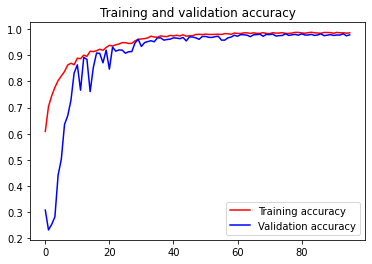

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

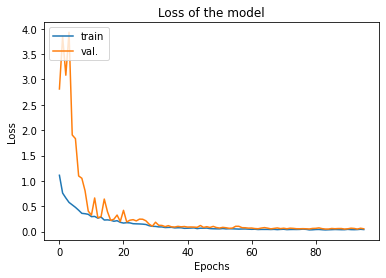

In [ ]:
# comparing training and testing loss 
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss of the model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val.'],loc='upper left')
plt.show()

# **Model Loading**

In [ ]:
model1A=load_model(Model_File_path+'model1_weights.h5')

# **Model Evaluation**

In [ ]:
A1=model1A.evaluate(test)
A1

21/21 [==============================] - 193s 10s/step - loss: 0.1189 - accuracy: 0.9619


[0.11890585720539093, 0.9618611931800842]

In [ ]:
pred_test = model1A.predict(test, verbose=1)

21/21 [==============================] - 234s 12s/step


In [ ]:
classes=list(train.class_indices.keys())


predict_labels_Test
Numbre of glioma : 277
Numbre of meningioma : 297
Numbre of notumor : 432
Numbre of pituitary : 305

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       277
           1       0.92      0.95      0.94       297
           2       1.00      0.94      0.97       432
           3       1.00      0.98      0.99       305

   micro avg       0.96      0.96      0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311
 samples avg       0.96      0.96      0.96      1311

Confusion Matrix


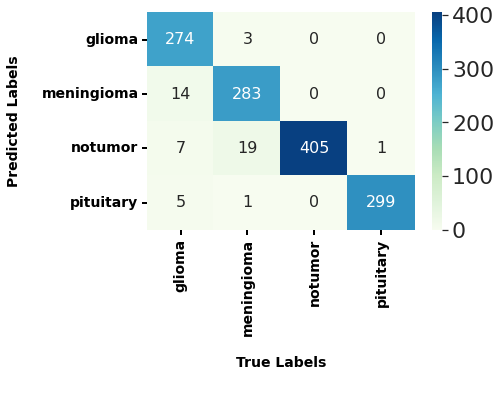

In [ ]:
predict_labels_Test = pred_test
predict_labels_Test1 = predict_labels_Test
predict_labels=np.argmax(predict_labels_Test, axis=1)
# print(predict_labels)

predict_labels_TestV2_ctg = np_utils.to_categorical(predict_labels, num_classes)
labels_Test_ctg = np_utils.to_categorical(test.classes, num_classes)
predict_labels_Ar = np.asarray(predict_labels)
print("\npredict_labels_Test")
print(f'Numbre of {classes[0]} : {(predict_labels_Ar == 0).sum()}')
print(f'Numbre of {classes[1]} : {(predict_labels_Ar == 1).sum()}')
print(f'Numbre of {classes[2]} : {(predict_labels_Ar == 2).sum()}')
print(f'Numbre of {classes[3]} : {(predict_labels_Ar == 3).sum()}')

print("\n"+classification_report(predict_labels_TestV2_ctg, labels_Test_ctg))

cm = confusion_matrix(predict_labels, test.classes) 
#cm1=np.array([[126, 1, 3], [0,193,9],[0,7,190]])
print('Confusion Matrix')
plt.figure()
ax= plt.subplot()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(which='major', width=1.00)
ax.tick_params(which='major', length=5)
ax.tick_params(which='minor', width=0.75)
ax.tick_params(which='minor', length=2.5)
ax.tick_params(direction='out', length=5, width=2, colors='black',
               grid_color='black', grid_alpha=0.5)
sns.set(font_scale=2)
sns.heatmap(cm, annot= True, fmt='', cmap='GnBu', cbar=True, annot_kws={"size": 16})
labels=classes
plt.rcParams.update(andy_theme)
ax.set_xlabel("\nTrue Labels\n" ,fontweight="bold")
ax.set_ylabel("Predicted Labels\n" ,fontweight="bold")
#ax.set_title('Confusion Matrix of VGG 16 Model',fontweight="bold"); 
ax.xaxis.set_ticklabels(labels,fontweight="bold", rotation = 90,); 
ax.yaxis.set_ticklabels(labels,fontweight="bold", rotation = 0,);

plt.show()


In [ ]:
test_classes=to_categorical(test.classes)

In [ ]:
Accuracy=accuracy_score(test.classes,predict_labels)
Accuracy

0.96186117467582

# **ROC_AUC Curve**

In [ ]:
AUC=roc_auc_score(test_classes,pred_test)
AUC  

0.997704351784781

ROC AUC score: 0.9727753564242295


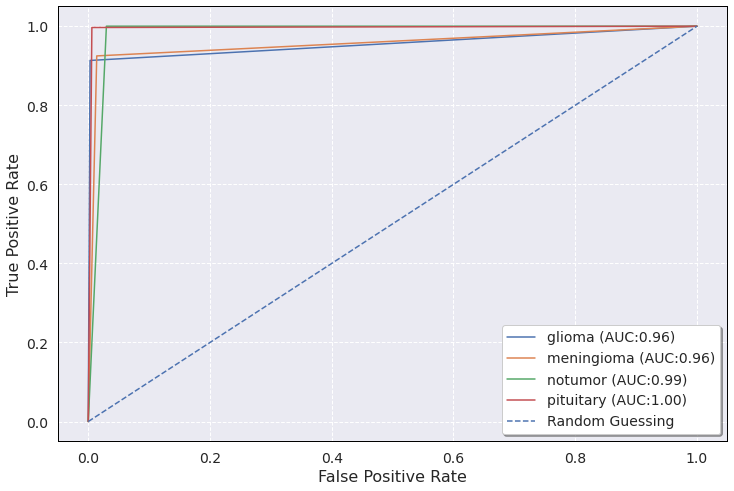

In [ ]:
target= list(test.class_indices.keys())

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', linestyle='--',label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(test.classes,predict_labels))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()


# **Model Testing**

In [ ]:
test = test_generator.flow_from_directory(test_data_dir, 
                                          target_size=(512,512),
                                          shuffle=True,
                                          batch_size=64, 
                                          class_mode= "sparse",
                                          color_mode='grayscale')


Found 1311 images belonging to 4 classes.


In [ ]:
class_names=['glioma', 'meningioma', 'notumor', 'pituitary']

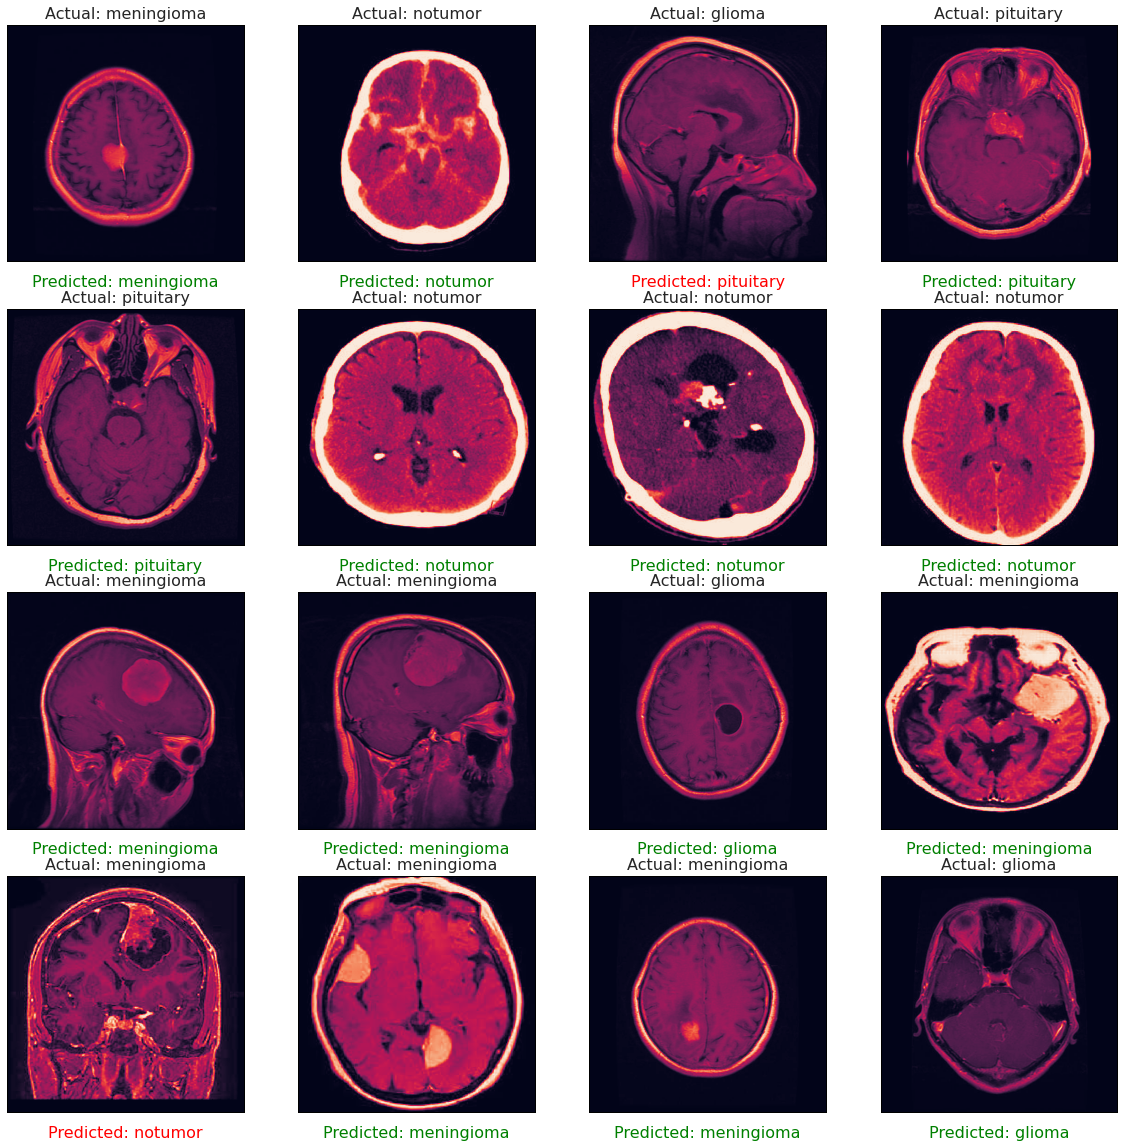

In [ ]:
images, labels = next(test)
plt.figure(figsize=(20, 20))
for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        image = cv2.resize(images[i], (512,512))
        plt.imshow(image)
        plt.grid()
        image = cv2.resize(images[i], (64,64))
        image = tf.keras.utils.img_to_array(image)
        # img_array = tf.expand_dims(img_array, 0) # Create a batch
        predictions = model1A.predict(tf.expand_dims(image, 0))
        score = tf.nn.softmax(predictions[0])
        if(class_names[int(labels[i])]==class_names[np.argmax(score)]):
            plt.title("Actual: "+ class_names[int(labels[i])],fontsize=16)
            plt.xlabel("Predicted: "+ class_names[np.argmax(score)],fontsize=16,fontdict={'color':'green'})
            
        else:
            plt.title("Actual: "+ class_names[int(labels[i])],fontsize=16)
            plt.xlabel("Predicted: "+ class_names[np.argmax(score)],fontsize=16, fontdict={'color':'red'})
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])